In [ ]:
# Зашумить изображение при помощи шума гаусса, постоянного шума.
# Протестировать медианный фильтр, фильтр гаусса, билатериальный фильтр, фильтр нелокальных средних с различными параметрами.
# Выяснить, какой фильтр показал лучший результат фильтрации шума.

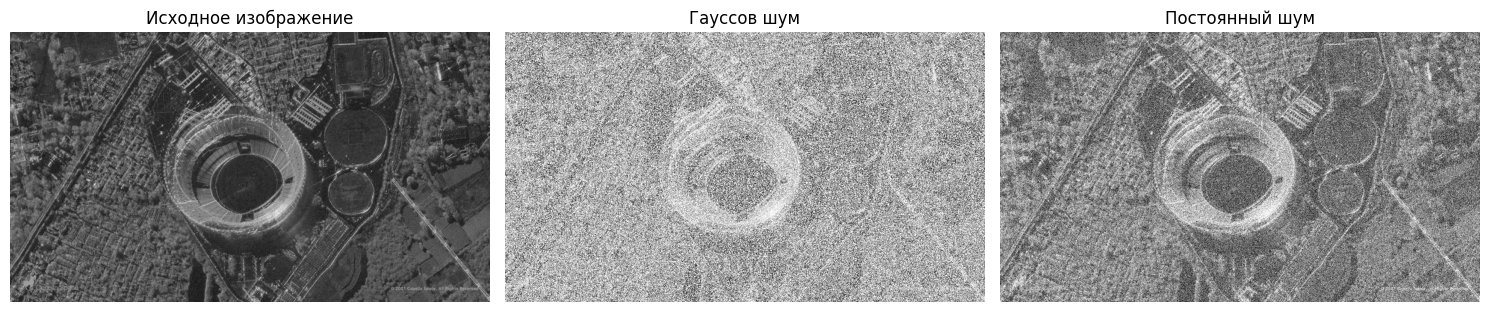

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim

image_path = "sar_1.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Файл {image_path} не найден.")

mean, sigma = 0, 25
noise_gauss = np.random.normal(mean, sigma, img.shape).astype(np.uint8)
img_gauss = cv2.add(img, noise_gauss)

a, b = 110, 0
mid = (a+b)/2
stdev = a - mid
noise_const = np.zeros(img.shape, np.float32)
cv2.randn(noise_const, mid, stdev)
img_const = np.clip(img.astype(np.float32)+noise_const, 0, 255).astype(np.uint8)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Исходное изображение")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_gauss, cmap='gray')
plt.title("Гауссов шум")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img_const, cmap='gray')
plt.title("Постоянный шум")
plt.axis('off')
plt.tight_layout()
plt.show()

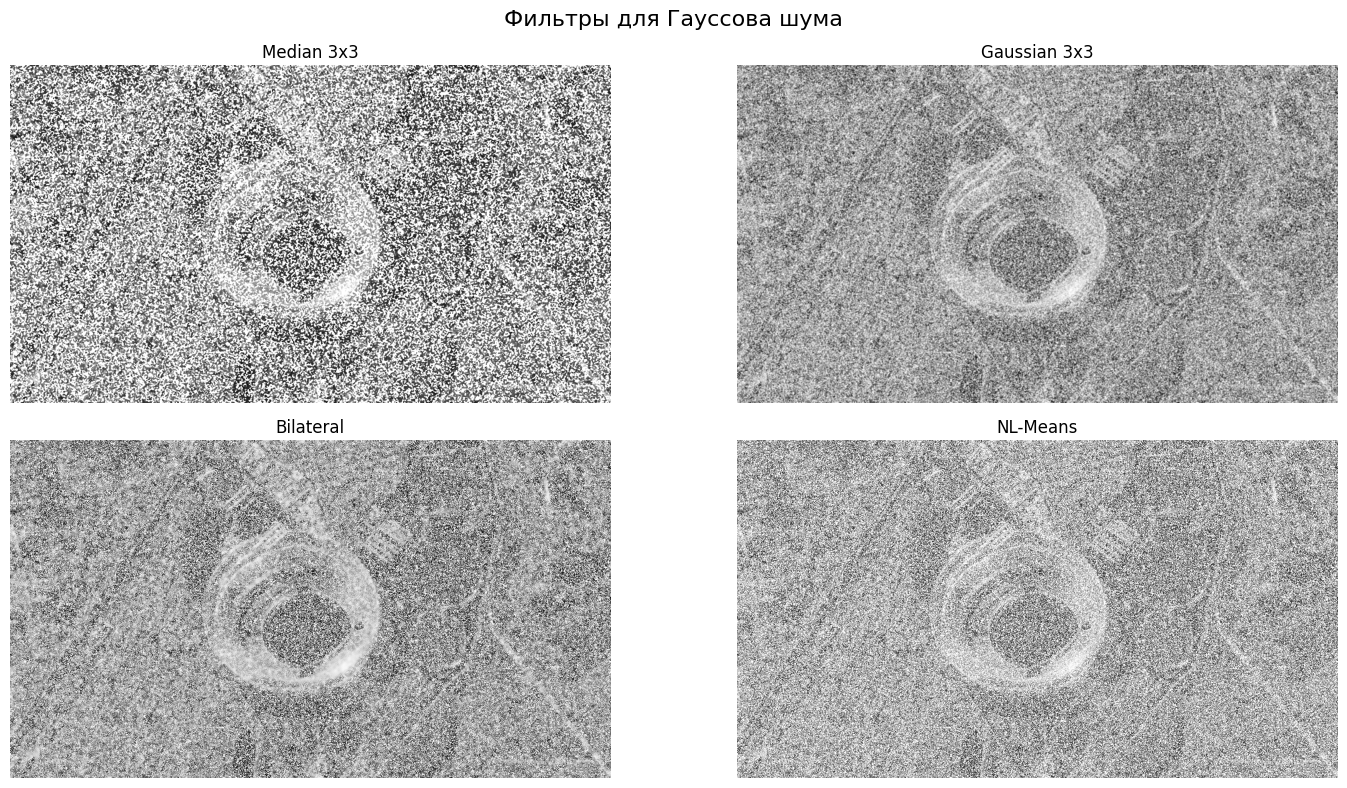

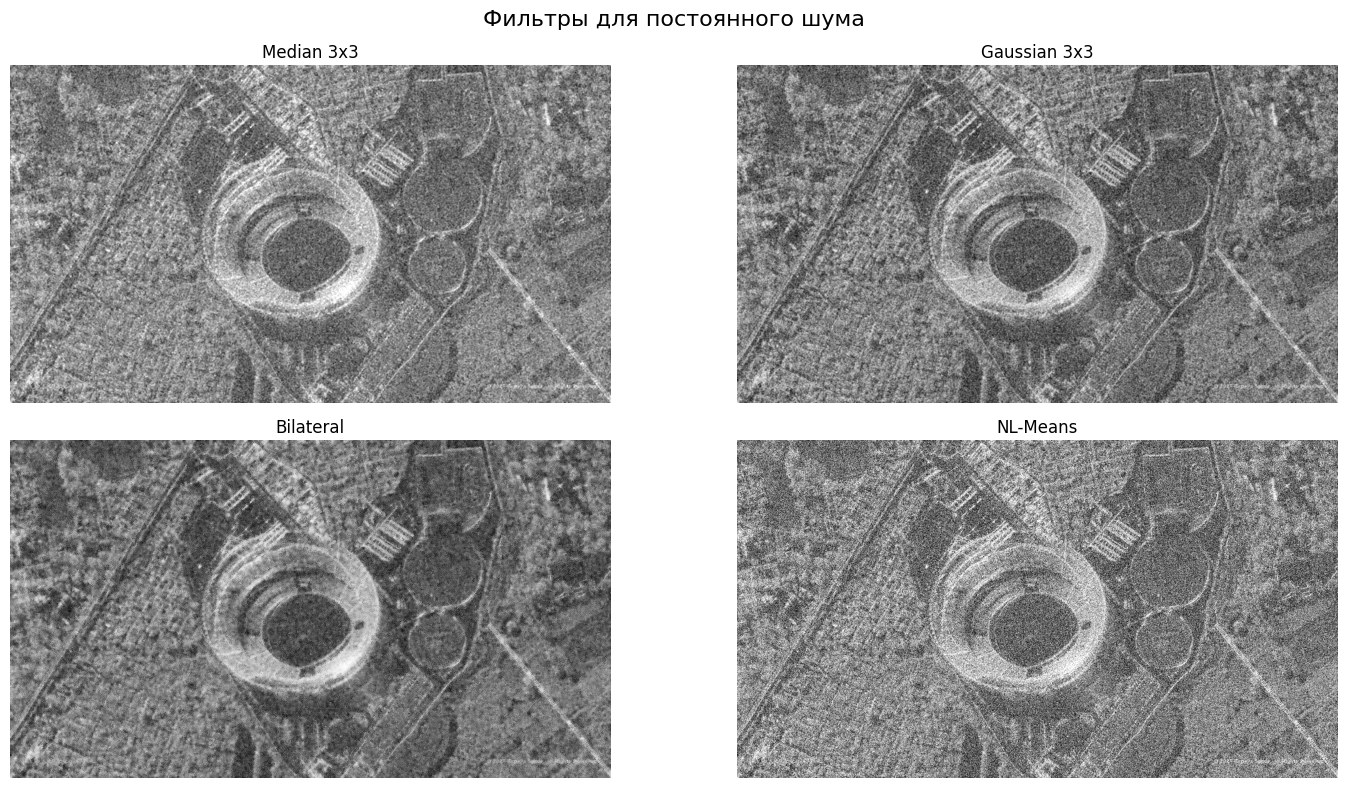

Результаты фильтрации (MSE, SSIM, PSNR):

Шум Гаусса:
Фильтр			MSE		SSIM		PSNR
Median 3x3     	15670.26		0.0543		27.57
Gaussian 3x3   	10302.06		0.1756		27.86
Bilateral      	13786.86		0.0707		27.62
NL-Means       	15865.81		0.0559		28.11

Постоянный шум:
Фильтр			MSE		SSIM		PSNR
Median 3x3     	3574.95		0.3487		27.57
Gaussian 3x3   	3391.26		0.4136		27.53
Bilateral      	3513.18		0.3382		27.56
NL-Means       	5717.90		0.1717		27.87

Лучший фильтр для шума Гаусса: NL-Means
Лучший фильтр для постоянного шума: NL-Means


In [7]:
filters_gauss = {
    "Median 3x3": cv2.medianBlur(img_gauss, 3),
    "Gaussian 3x3": cv2.GaussianBlur(img_gauss, (3,3), 0),
    "Bilateral": cv2.bilateralFilter(img_gauss, 9, 75, 75),
    "NL-Means": cv2.fastNlMeansDenoising(img_gauss, None, 10, 7, 21)
}

filters_const = {
    "Median 3x3": cv2.medianBlur(img_const, 3),
    "Gaussian 3x3": cv2.GaussianBlur(img_const, (3,3), 0),
    "Bilateral": cv2.bilateralFilter(img_const, 9, 75, 75),
    "NL-Means": cv2.fastNlMeansDenoising(img_const, None, 10, 7, 21)
}

def plot_filters(filtered_dict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle(title, fontsize=16)
    for i, (name, filtered) in enumerate(filtered_dict.items()):
        plt.subplot(2,2,i+1)
        plt.imshow(filtered, cmap='gray')
        plt.title(name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_filters(filters_gauss, "Фильтры для Гауссова шума")
plot_filters(filters_const, "Фильтры для постоянного шума")

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_metrics(original, filtered):
    mse = mean_squared_error(original, filtered)
    ssim_val = ssim(original, filtered, data_range=255)
    psnr_val = calculate_psnr(original, filtered)
    return mse, ssim_val, psnr_val

results_gauss = {}
for filter_name, filtered_img in filters_gauss.items():
    mse, ssim_val, psnr_val = calculate_metrics(img, filtered_img)
    results_gauss[filter_name] = (mse, ssim_val, psnr_val)

results_const = {}
for filter_name, filtered_img in filters_const.items():
    mse, ssim_val, psnr_val = calculate_metrics(img, filtered_img)
    results_const[filter_name] = (mse, ssim_val, psnr_val)

print("Результаты фильтрации (MSE, SSIM, PSNR):")
print("\nШум Гаусса:")
print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
for filter_name, metrics in results_gauss.items():
    mse, ssim_val, psnr_val = metrics
    print(f"{filter_name:15}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

print("\nПостоянный шум:")
print("Фильтр\t\t\tMSE\t\tSSIM\t\tPSNR")
for filter_name, metrics in results_const.items():
    mse, ssim_val, psnr_val = metrics
    print(f"{filter_name:15}\t{mse:.2f}\t\t{ssim_val:.4f}\t\t{psnr_val:.2f}")

best_gn_filter = max(results_gauss, key=lambda k: results_gauss[k][2])
best_constant_filter = max(results_const, key=lambda k: results_const[k][2])

print(f"\nЛучший фильтр для шума Гаусса: {best_gn_filter}")
print(f"Лучший фильтр для постоянного шума: {best_constant_filter}")